In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf

In [4]:
names = [
    'fLength',
    'fWidth',
    'fSize',
    'fConc',
    'fConc1',
    'fAsym',
    'fM3Long',
    'fM3Trans',
    'fAlpha',
    'fDist',
    'class'
]

df = pd.read_csv('../magic04.data', names=names)
df['class'] = (df['class'] == 'g').astype(int)
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1


In [5]:
def scaledataset(dataframe, oversample = False):
    X = dataframe[dataframe.columns[:-1]].values
    y = dataframe[dataframe.columns[-1]].values

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y) # type: ignore

    data = np.hstack((X, np.reshape(y, (-1, 1))))

    return data, X, y

In [11]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6 * len(df)), int(0.8 * len(df))])

train, X_train, y_train = scaledataset(train, oversample=True)
valid, X_valid, y_valid = scaledataset(valid, oversample=False)
test, X_test, y_test = scaledataset(test, oversample=False)

In [20]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary crossentropy')
    ax1.grid(True)

    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)
    plt.legend()

    plt.show()

In [15]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(tf.keras.layers.Dropout(0.15))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.15))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.15))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [16]:
history = model.fit(X_train, y_train,
          epochs=250, batch_size=64,
          validation_data=(X_valid, y_valid))

Epoch 1/250
231/231 [==============================] - 3s 4ms/step - loss: 0.4989 - accuracy: 0.7542 - val_loss: 0.4132 - val_accuracy: 0.8134
Epoch 2/250
231/231 [==============================] - 1s 3ms/step - loss: 0.4267 - accuracy: 0.8028 - val_loss: 0.3926 - val_accuracy: 0.8236
Epoch 3/250
231/231 [==============================] - 1s 3ms/step - loss: 0.4081 - accuracy: 0.8148 - val_loss: 0.3848 - val_accuracy: 0.8336
Epoch 4/250
231/231 [==============================] - 1s 3ms/step - loss: 0.3926 - accuracy: 0.8245 - val_loss: 0.3598 - val_accuracy: 0.8538
Epoch 5/250
231/231 [==============================] - 1s 3ms/step - loss: 0.3846 - accuracy: 0.8264 - val_loss: 0.3544 - val_accuracy: 0.8544
Epoch 6/250
231/231 [==============================] - 1s 2ms/step - loss: 0.3743 - accuracy: 0.8344 - val_loss: 0.3426 - val_accuracy: 0.8620
Epoch 7/250
231/231 [==============================] - 1s 3ms/step - loss: 0.3681 - accuracy: 0.8341 - val_loss: 0.3440 - val_accuracy: 0.8591

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


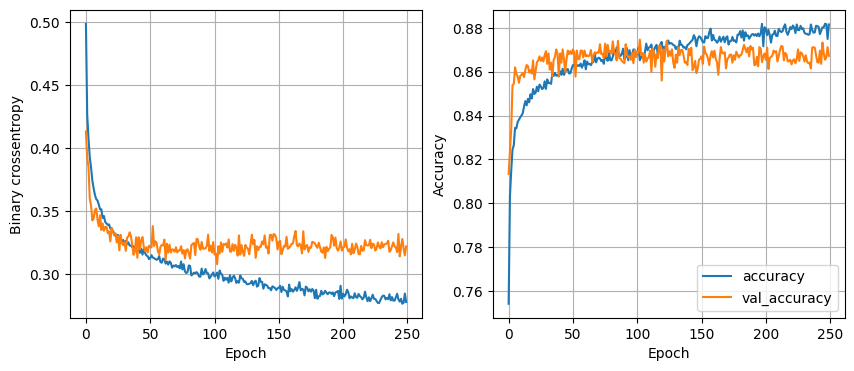

In [21]:
plot_history(history)

In [43]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1)
print(classification_report(y_test, y_pred))

119/119 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.81      0.80      0.80      1328
           1       0.89      0.90      0.90      2476

    accuracy                           0.86      3804
   macro avg       0.85      0.85      0.85      3804
weighted avg       0.86      0.86      0.86      3804



In [39]:
model.save('basic-telescope-model.h5')

In [40]:
del model

In [42]:
model = tf.keras.models.load_model('basic-telescope-model.h5')